# Scheduling benchmarks analysis

## Library

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
from enum import Enum
import benchmarks_lib
import graphing_lib
import seaborn as sns
from collections import defaultdict

import importlib
importlib.reload(benchmarks_lib)
importlib.reload(graphing_lib)
from benchmarks_lib import get_batch_dataframe
from graphing_lib import BoxPlotter, DisplayType

#### Global variables

In [3]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "/root/results"
TRACE_CMD_SUB_DIR = "_trace-cmd"

USE_TRACE_CMD_CACHE = True

def in_result_dir(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def in_trace_cmd_dir(benchmark_dir_name) :
    return in_result_dir(os.path.join(TRACE_CMD_SUB_DIR, benchmark_dir_name))

In [4]:
# df = get_batch_dataframe(in_result_dir("new/bt.B.x__yeti-2__v6.8.0-rc3__performance__2024-06-29/nb-disabled-none"))
# df

# df = get_batch_dataframe(in_trace_cmd_dir("bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08/nb-disabled-none"), use_cache=True, cache_filename=TRACE_CMD_CACHE_FILENAME)
# df

#### Visualization params

In [5]:
DEFAULT_FIGURE_HEIGHT = 12

nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = DEFAULT_FIGURE_HEIGHT
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

In [6]:
batches_pinnings = [
    ["nb-disabled-sockets", "nb-enabled-sockets"],
    ["nb-disabled-sockorder", "nb-enabled-sockorder"],
    ["nb-disabled-sequential", "nb-enabled-sequential"],
    ["nb-disabled-none", "nb-enabled-none"]
]

omp_pinnings = {
    "sockets": ["nb-disabled-sockets", "nb-enabled-sockets"],
    "sockorder": ["nb-disabled-sockorder", "nb-enabled-sockorder"],
    "sequential": ["nb-disabled-sequential", "nb-enabled-sequential"],
    "none": ["nb-disabled-none", "nb-enabled-none"]
}


two_nodes_benchmarks = [
    "bt.B.x__dahu-15__v6.8.0-rc3__performance__2024-03-08",
    "bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08",
    # "cg.A.x__dahu-22__v6.8.0-rc3__performance__2024-04-26",
    "cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26",
    "cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26",
    "ft.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09",
    "lu.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09",
    "mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09",
    "sp.B.x__dahu-13__v6.8.0-rc3__performance__2024-03-09",
    "sp.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09",
    "ua.C.x__dahu-13__v6.8.0-rc3__performance__2024-03-09",
]


# TODO :
# Run experiments for :
# - bt.B
# - cg.B and C (maybe A ?)
# - mg.D
# - sp.C
four_nodes_benchmarks = [
    "bt.B.x__yeti-2__v6.8.0-rc3__performance__2024-06-29",
    "bt.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11",
    "cg.B.x__yeti-2__v6.8.0-rc3__performance__2024-06-29",
    "cg.C.x__yeti-2__v6.8.0-rc3__performance__2024-06-29",
    "ft.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11",
    "lu.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11",
    "mg.D.x__yeti-2__v6.8.0-rc3__performance__2024-06-29",
    "sp.B.x__yeti-1__v6.8.0-rc3__performance__2024-03-11",
    "sp.C.x__yeti-2__v6.8.0-rc3__performance__2024-06-29",
    "ua.C.x__yeti-1__v6.8.0-rc3__performance__2024-03-11",
]

combined_benchmarks = [(b, 2) for b in two_nodes_benchmarks] + [(b, 4) for b in four_nodes_benchmarks]

## Effects of NUMA balancing for each benchmark

For each numa pinning, compute the average of nb-enabled, nb-disabled, and variation is variation between these 2 averages

### Analysis helper : size of each benchmark folder

In [8]:
benchmarks = sorted(os.listdir(in_trace_cmd_dir("")))
for c in benchmarks :
    print(c)
    benchmark_path = os.path.join(in_trace_cmd_dir(""), c)
    if not os.path.isdir(benchmark_path) :
        continue
    
    descriptions = []
    batches = os.listdir(benchmark_path)
    for batch in batches:
        batch_path = os.path.join(benchmark_path, batch)
        df = get_batch_dataframe(
            batch_path, 
            use_cache=True, 
            cache_filename=TRACE_CMD_CACHE_FILENAME, 
            include_broken_wc =False
        )
        print(f"{batch} : {len(df)}")
        # descriptions.append(f"{batch} : {len(df)}")
    # print(" - ".join(descriptions))
    print("")
    
  

bt.B.x__dahu-15__v6.8.0-rc3__performance__2024-03-08
nb-enabled-sockorder : 20
nb-disabled-sequential : 20
nb-disabled-sockets : 20
nb-enabled-none : 20
nb-enabled-sequential : 20
nb-disabled-sockorder : 20
nb-disabled-none : 20
nb-enabled-sockets : 20

bt.B.x__yeti-2__v6.8.0-rc3__performance__2024-06-29
nb-enabled-sockorder : 50
nb-disabled-sequential : 50
nb-disabled-sockets : 50
nb-enabled-none : 50
nb-enabled-sequential : 50
nb-disabled-sockorder : 50
nb-disabled-none : 50
nb-enabled-sockets : 50

bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08
nb-enabled-sockorder : 20
nb-disabled-sequential : 20
nb-disabled-sockets : 20
nb-enabled-none : 20
nb-enabled-sequential : 20
nb-disabled-sockorder : 20
nb-disabled-none : 20
nb-enabled-sockets : 20

bt.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11
nb-enabled-sockorder : 20
nb-disabled-sequential : 20
nb-disabled-sockets : 20
nb-enabled-none : 20
nb-enabled-sequential : 20
nb-disabled-sockorder : 20
nb-disabled-none : 20
nb-enabled-

In [9]:

def get_average_runtime_for_batch(batch_path: str):
    batch_df = get_batch_dataframe(
        batch_path, 
        use_cache=True, 
        cache_filename=TRACE_CMD_CACHE_FILENAME, 
        include_broken_wc = False
    )
    return batch_df["duration"].mean(), len(batch_df)


def compute_average_nb_variation_for_benchmark(benchmark_dir_path, debug = False):
    total_disabled_runtime = 0
    n_disabled_runtime = 0
    
    total_var = 0
    n_var = 0
    for disabled_name, enabled_name in batches_pinnings :
        disabled_path = os.path.join(benchmark_dir_path, disabled_name)
        enabled_path = os.path.join(benchmark_dir_path, enabled_name)
        
        if not os.path.exists(disabled_path):
            print(f"Cannot find {disabled_path}")
            continue
        if  not os.path.exists(enabled_path):
            print(f"Cannot find {enabled_path}")
            continue
        
        disabled_average, disabled_len = get_average_runtime_for_batch(disabled_path)
        enabled_average, enabled_len = get_average_runtime_for_batch(enabled_path)
        
        total_disabled_runtime += (disabled_average * disabled_len)
        n_disabled_runtime += disabled_len
        
        mid_len = (disabled_len + enabled_len) / 2
        variation = (enabled_average - disabled_average) * 100 / disabled_average
        # print(f"{disabled_name} : {disabled_average} (N = {disabled_len}), {enabled_name} : {enabled_average} (N = {enabled_len}), var : {variation}, mid_len : {mid_len}")
        if debug:
            print(f"{disabled_len} {disabled_name}, {enabled_len} {enabled_name}, var : {variation}")
        total_var += (variation * mid_len)
        n_var += mid_len
    if n_var == 0:
        print("Error, no variation computed")
        return
    return total_var / n_var, total_disabled_runtime / n_disabled_runtime

# Returns a dict [pinning_name : (variation, n_samples)]
def compute_nb_variation_per_pinning_for_benchmark(benchmark_dir_path, debug = False) -> Dict[str, Tuple[float, float]]:
    # print(benchmark_dir_path)
    result_dict = {} # Contains [variation, size, average] for each pinning name
    
    for pinning_name, (disabled_name, enabled_name) in omp_pinnings.items() :
        disabled_path = os.path.join(benchmark_dir_path, disabled_name)
        enabled_path = os.path.join(benchmark_dir_path, enabled_name)
        
        if not os.path.exists(disabled_path):
            print(f"Cannot find {disabled_path}")
            continue
        if  not os.path.exists(enabled_path):
            print(f"Cannot find {enabled_path}")
            continue
        
        disabled_average, disabled_size = get_average_runtime_for_batch(disabled_path)
        enabled_average, enabled_size = get_average_runtime_for_batch(enabled_path)
        total = disabled_size + enabled_size
        average = ((disabled_average * disabled_size) + (enabled_average * enabled_size)) / total
        
        variation = (enabled_average - disabled_average) * 100 / disabled_average
        if debug:
            print(f"{disabled_size} {disabled_name}, {enabled_size} {enabled_name}, var : {variation}")
        
        result_dict[pinning_name] = (variation, total, average)
    return result_dict


# Deprecated
def compute_variation_by_pinning_for_benchmark(benchmark_dir_path, reference_pinning_name = "sockets", debug = False):
    # Compute the average over NB on and off for each pinning
    # Then compute the variation between that and the average for the reference pinning
    # print(benchmark_dir_path)
    averages_dict = {} # Contains (global average, number_samples) for each pinning name
    
    for pinning_name, (disabled_name, enabled_name) in omp_pinnings.items() :
        disabled_path = os.path.join(benchmark_dir_path, disabled_name)
        enabled_path = os.path.join(benchmark_dir_path, enabled_name)
        
        if not os.path.exists(disabled_path):
            print(f"Cannot find {disabled_path}")
            continue
        if  not os.path.exists(enabled_path):
            print(f"Cannot find {enabled_path}")
            continue
        
        if debug:
            print(f"{disabled_len} {disabled_name}, {enabled_len} {enabled_name}, var : {variation}")
            
        disabled_average, disabled_len = get_average_runtime_for_batch(disabled_path)
        enabled_average, enabled_len = get_average_runtime_for_batch(enabled_path)
        total_len = disabled_len + enabled_len
        general_average = ((disabled_average * disabled_len) + (enabled_average * enabled_len)) / total_len
        averages_dict[pinning_name] = (general_average, total_len)
        
    if reference_pinning_name not in averages_dict:
        print(f"Unable to get data on reference pinning {reference_pinning_name} for benchmark {benchmark_dir_path}")
        
    def result_values_for_pinning(pinning_name):
        av, n = averages_dict[pinning_name]
        variation = (av - averages_dict[reference_pinning_name][0]) * 100 / averages_dict[reference_pinning_name][0]
        return (variation, n)
        
    return {pinning_name: result_values_for_pinning(pinning_name) for pinning_name in averages_dict}




def compute_variation_between_pinning_for_benchmark(benchmark_dir_path, reference_pinning_name = "sockorder", debug = False):
    # Compute the average over NB on and off for each pinning
    # Then compute the variation between that and the average for the reference pinning
    averages_dict = {} # Contains (global average, number_samples) for each pinning name
    
    for pinning_name, (disabled_name, enabled_name) in omp_pinnings.items() :
        disabled_path = os.path.join(benchmark_dir_path, disabled_name)
        enabled_path = os.path.join(benchmark_dir_path, enabled_name)
        
        if not os.path.exists(disabled_path):
            print(f"Cannot find {disabled_path}")
            continue
        if  not os.path.exists(enabled_path):
            print(f"Cannot find {enabled_path}")
            continue
        
        disabled_df = get_batch_dataframe(disabled_path, use_cache=True, cache_filename=TRACE_CMD_CACHE_FILENAME, include_broken_wc=False)
        enabled_df = get_batch_dataframe(enabled_path, use_cache=True, cache_filename=TRACE_CMD_CACHE_FILENAME, include_broken_wc=False)
        combined_df = pd.concat([disabled_df, enabled_df], axis=0)
        print(combined_df)
        averages_dict[pinning_name] = (combined_df["duration"].mean(), len(combined_df))
        
    if reference_pinning_name not in averages_dict:
        print(f"Unable to get data on reference pinning {reference_pinning_name} for benchmark {benchmark_dir_path}")
        
    def result_values_for_pinning(pinning_name):
        av, n = averages_dict[pinning_name]
        variation = (av - averages_dict[reference_pinning_name][0]) * 100 / averages_dict[reference_pinning_name][0]
        return (variation, n)
        
    return {pinning_name: result_values_for_pinning(pinning_name) for pinning_name in averages_dict}


def compute_variation_between_pinning_for_benchmark_for_nb(benchmark_dir_path: str, nb: bool, reference_pinning_name = "sockorder", debug = False):
    # Compute the average over NB on and off for each pinning
    # Then compute the variation between that and the average for the reference pinning
    averages_dict = {} # Contains (global average, number_samples) for each pinning name
    
    for pinning_name, (disabled_name, enabled_name) in omp_pinnings.items() :
        batch_name = enabled_name if nb else disabled_name
        batch_path = os.path.join(benchmark_dir_path, batch_name)
        
        if not os.path.exists(batch_path):
            print(f"Cannot find {batch_path}")
            continue
        
        df = get_batch_dataframe(batch_path, use_cache=True, cache_filename=TRACE_CMD_CACHE_FILENAME, include_broken_wc=False)
        averages_dict[pinning_name] = (df["duration"].mean(), len(df))
        
    if reference_pinning_name not in averages_dict:
        print(f"Unable to get data on reference pinning {reference_pinning_name} for benchmark {benchmark_dir_path}")
        
    def result_values_for_pinning(pinning_name):
        av, n = averages_dict[pinning_name]
        variation = (av - averages_dict[reference_pinning_name][0]) * 100 / averages_dict[reference_pinning_name][0]
        return (variation, n)
        
    return {pinning_name: result_values_for_pinning(pinning_name) for pinning_name in averages_dict}



# compute_average_nb_variation_for_benchmark(in_trace_cmd_dir("bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08"))
# compute_average_nb_variation_for_benchmark(in_trace_cmd_dir("cg.A.x__dahu-11__v6.8.0-rc3__performance__2024-04-26"))
# benchmark_dir_path = in_trace_cmd_dir("bt.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-08")
# contents = os.listdir()
    # os.path.exists()
    
    
def benchmark_pretty_name(benchmark_name: str):
    parts = benchmark_name.split('.')
    return f"{parts[0].upper()} - {parts[1].upper()}"
   

In [10]:
# compute_average_nb_variation_for_benchmark(in_trace_cmd_dir("cg.C.x__dahu-17__v6.8.0-rc3__performance__2024-04-26"))

In [11]:
# compute_average_nb_variation_for_benchmark(in_trace_cmd_dir("cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26"))

#### Display values for all the benchmarks

In [12]:
filter_str = "yeti"
benchmarks = sorted(os.listdir(in_trace_cmd_dir("")))
for bench in benchmarks :
    if not filter_str in bench: 
        continue
    benchmark_path = os.path.join(in_trace_cmd_dir(""), bench)
    if not os.path.isdir(benchmark_path) :
        continue
    bench_average, average_runtime = compute_average_nb_variation_for_benchmark(benchmark_path, debug=True)
    print(f"{bench} : {bench_average}, average runtime : {average_runtime}")
    print("")

50 nb-disabled-sockets, 50 nb-enabled-sockets, var : -0.010138230958829339
50 nb-disabled-sockorder, 50 nb-enabled-sockorder, var : -3.301858571366639
50 nb-disabled-sequential, 50 nb-enabled-sequential, var : 0.7959102324463561
50 nb-disabled-none, 50 nb-enabled-none, var : 1.585758262246571
bt.B.x__yeti-2__v6.8.0-rc3__performance__2024-06-29 : -0.23258207690813534, average runtime : 4.566210561315

20 nb-disabled-sockets, 20 nb-enabled-sockets, var : 2.998777722014445
20 nb-disabled-sockorder, 20 nb-enabled-sockorder, var : 1.7072367390174974
20 nb-disabled-sequential, 20 nb-enabled-sequential, var : 0.26292462111778103
20 nb-disabled-none, 20 nb-enabled-none, var : 9.367349166614725
bt.C.x__yeti-3__v6.8.0-rc3__performance__2024-03-11 : 3.5840720621911117, average runtime : 17.211014100000007

100 nb-disabled-sockets, 100 nb-enabled-sockets, var : 0.17322138711762802
100 nb-disabled-sockorder, 100 nb-enabled-sockorder, var : -0.7009342330195534
100 nb-disabled-sequential, 100 nb-enab

## Per benchmark analysis

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09/nb-enabled-sockets
Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - All Pinning Configuration
Positive values means NUMA balancing is worse


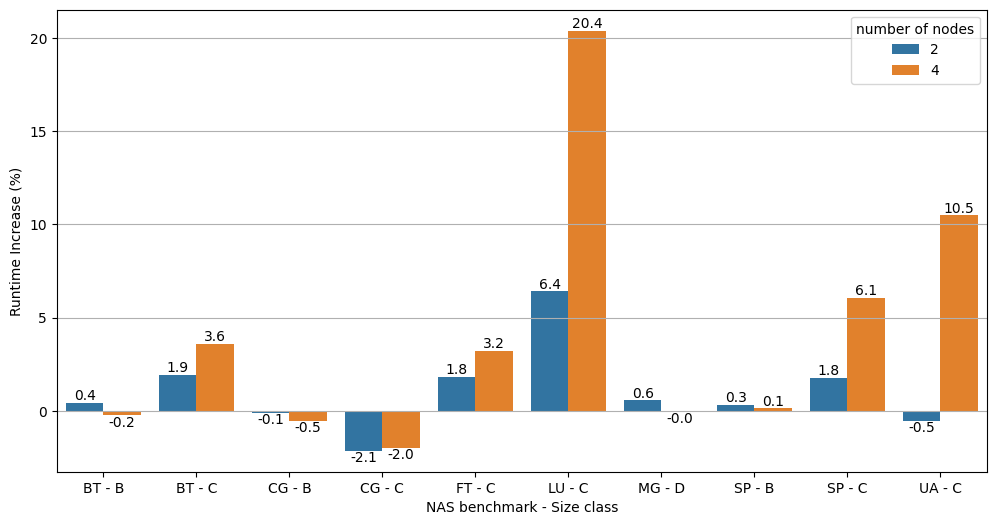

In [13]:
def compare_numab_per_benchmark_per_machine_type(benchmarks: List[Tuple[str, int]], w = 12, h = 6):
    # combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    nodes_values = []
    benchmark_values = []
    variation_values = []
    for name, n_nodes in benchmarks:
        variation, average_runtime = compute_average_nb_variation_for_benchmark(in_trace_cmd_dir(name))
        nodes_values.append(n_nodes)
        benchmark_values.append(benchmark_pretty_name(name))
        variation_values.append(variation)
      
    data_df = pd.DataFrame({
        "benchmark": benchmark_values,
        "variation": variation_values,
        "number of nodes": nodes_values
    })
    
    ax = sns.barplot(x='benchmark', y='variation', hue='number of nodes', data=data_df, palette='tab10')
    for container in ax.containers:
        # ax.bar_label(container, fmt='%.1f%%')
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y')
    plt.xlabel('NAS benchmark - Size class')
    plt.ylabel('Runtime Increase (%)')
    print(f'Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - All Pinning Configuration\nPositive values means NUMA balancing is worse')
    # plt.title(f'Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - All Pinning Configuration\nPositive values means NUMA balancing is worse')
    plt.show()
    
    
compare_numab_per_benchmark_per_machine_type(combined_benchmarks)

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09/nb-enabled-sockets
Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - Dual-Node Machines
Positive values means NUMA balancing is worse


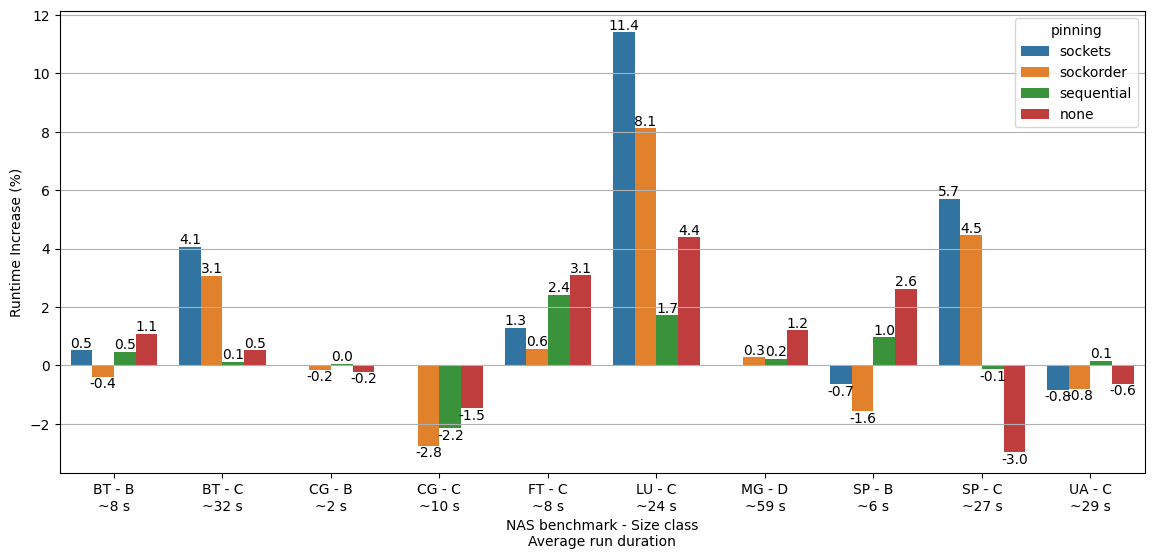

Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - Quad-Node Machines
Positive values means NUMA balancing is worse


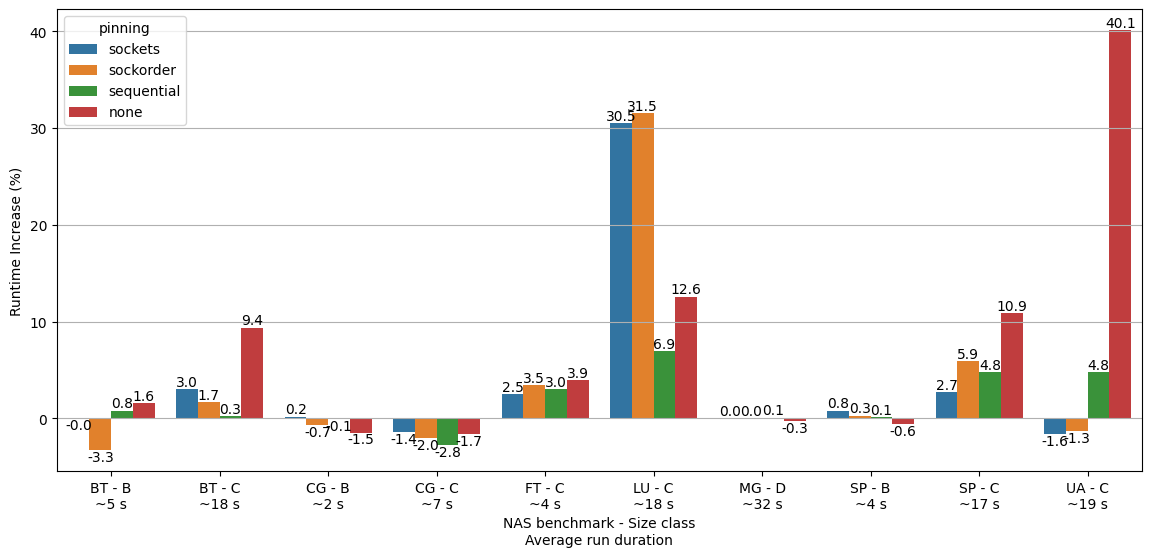

In [14]:

def compare_numab_per_benchmark_per_pinning(benchmarks_names, n_nodes, w = 14, h = 6):
    # combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    benchmark_averages = {}
    benchmark_values = []
    variation_values = []
    pinning_values = []
    for name in benchmarks_names:
        pretty_name = benchmark_pretty_name(name)
        variation_per_pinning = compute_nb_variation_per_pinning_for_benchmark(in_trace_cmd_dir(name))
        
        avg_sum = 0
        for pinning_name, (variation, n, avg) in variation_per_pinning.items():
            benchmark_values.append(pretty_name)
            variation_values.append(variation)
            pinning_values.append(pinning_name)
            avg_sum += avg
            
        benchmark_averages[pretty_name] = avg_sum / len(variation_per_pinning)
            
    data_df = pd.DataFrame({
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values
    })
    
    ax = sns.barplot(x='benchmark', y='variation', hue='pinning', data=data_df, palette='tab10')
    for container in ax.containers:
        # ax.bar_label(container, fmt='%.1f%%')
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y')
    plt.xlabel('NAS benchmark - Size class\nAverage run duration')
    plt.ylabel('Runtime Increase (%)')
    machine_type = "Dual-Node" if n_nodes == 2 else "Quad-Node"
    print(f'Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - {machine_type} Machines\nPositive values means NUMA balancing is worse')
    
    labels = [t.get_text() for t in plt.xticks()[1]]
    new_labels = [l + f"\n~{round(benchmark_averages[l])} s" for l in labels]
    plt.xticks(labels, new_labels)
    
    plt.show()
    
compare_numab_per_benchmark_per_pinning(two_nodes_benchmarks, 2)
compare_numab_per_benchmark_per_pinning(four_nodes_benchmarks, 4)

## Per pinning configuration analysis

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09/nb-enabled-sockets
Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF
Positive values means NUMA balancing is worse


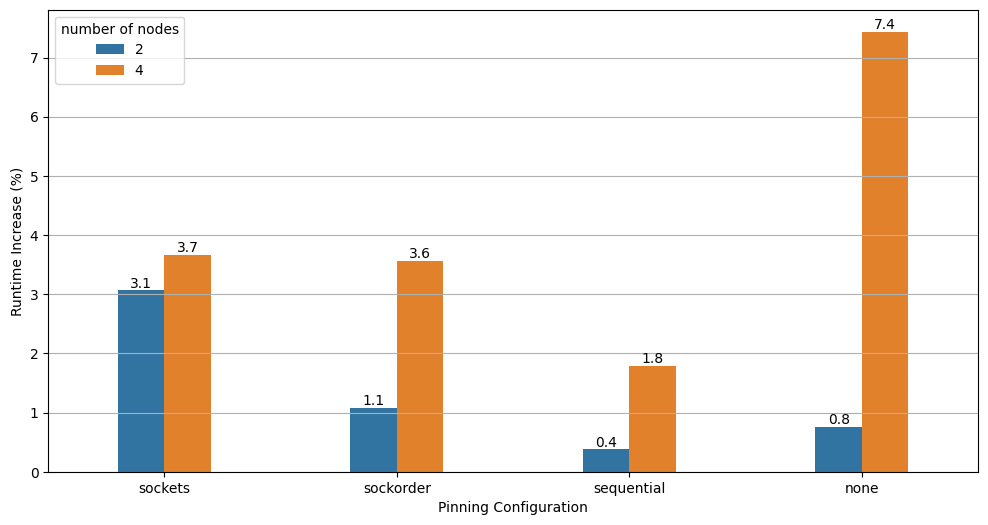

In [15]:
def compare_numab_per_pinning_per_machine_type(benchmarks: List[Tuple[str, int]], w = 12, h = 6):
    # combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    
    # We make the choice of giving a weight of 1 to each benchmark
    nodes_values = []
    benchmark_values = []
    variation_values = []
    pinning_values = []
    for name, n_nodes in benchmarks:
        var_per_pinning = compute_nb_variation_per_pinning_for_benchmark(in_trace_cmd_dir(name))
        for pinning_name, (variation, n, avg) in var_per_pinning.items():
            nodes_values.append(n_nodes)
            benchmark_values.append(name)
            variation_values.append(variation)
            pinning_values.append(pinning_name)
      
    data_df = pd.DataFrame({
        "number of nodes": nodes_values,
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values
    })
    aggregate_df = data_df.groupby(['pinning', 'number of nodes']).agg(average_var=("variation", "mean"))
    
    
    keys = list(omp_pinnings.keys())
    ax = sns.barplot(x='pinning', y='average_var', order=keys, hue='number of nodes', data=aggregate_df, palette='tab10', width=0.4)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y')
    plt.xlabel('Pinning Configuration')
    plt.ylabel('Runtime Increase (%)')
    print(f'Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF\nPositive values means NUMA balancing is worse')
    plt.show()
    
    
compare_numab_per_pinning_per_machine_type(combined_benchmarks)

WARNING \
Probably not relevant to show the following because it is just a reorganization of the analysis per benchmark with hue on pinning config

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/mg.D.x__dahu-15__v6.8.0-rc3__performance__2024-03-09/nb-enabled-sockets
Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - Dual-Node Machines
Positive values means NUMA balancing is worse


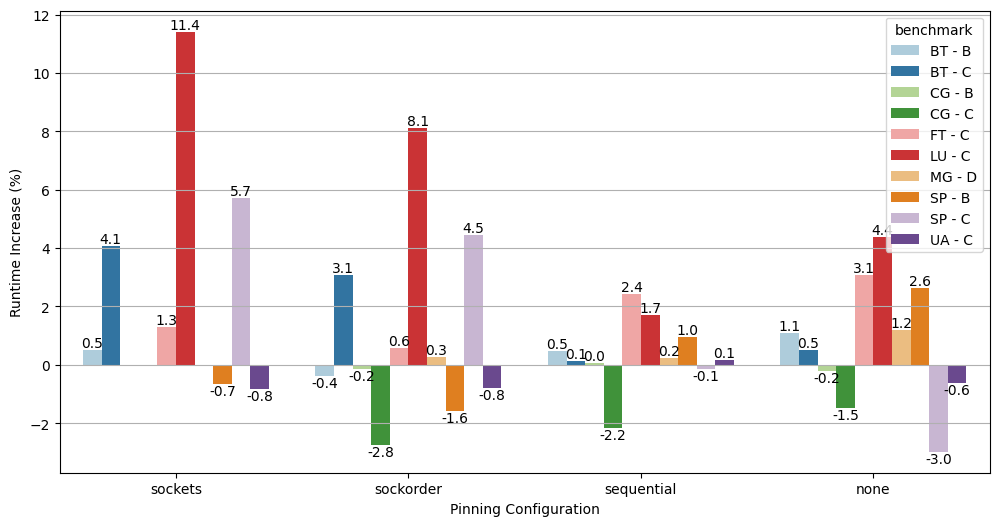

Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - Quad-Node Machines
Positive values means NUMA balancing is worse


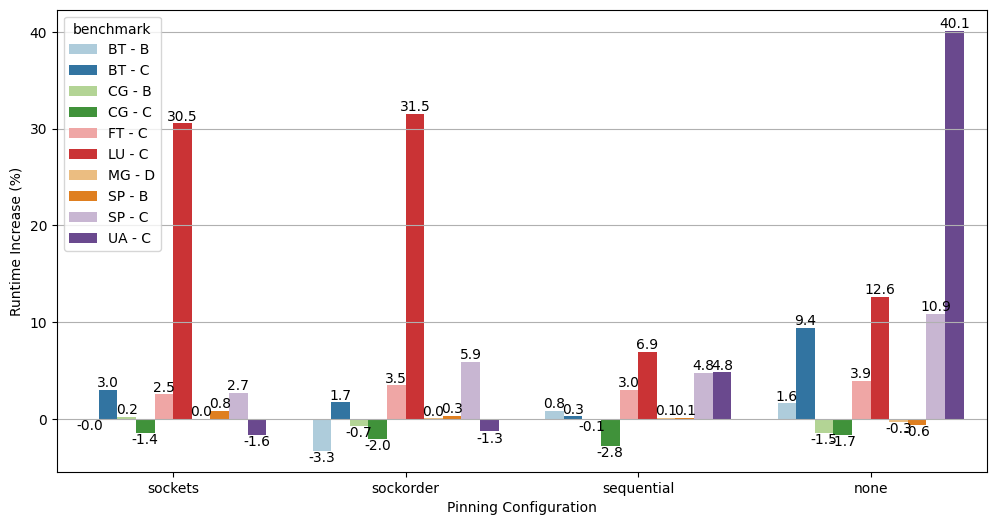

In [23]:
def compare_numab_per_pinning_per_benchmark(benchmarks_names: List[str], n_nodes: int, w = 12, h = 6):
    # combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    
    # We make the choice of giving a weight of 1 to each benchmark
    benchmark_values = []
    variation_values = []
    pinning_values = []
    for name in benchmarks_names:
        var_per_pinning = compute_nb_variation_per_pinning_for_benchmark(in_trace_cmd_dir(name))
        for pinning_name, (variation, n, avg) in var_per_pinning.items():
            benchmark_values.append(benchmark_pretty_name(name))
            variation_values.append(variation)
            pinning_values.append(pinning_name)
      
    data_df = pd.DataFrame({
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values
    })
    
    keys = list(omp_pinnings.keys())
    ax = sns.barplot(x='pinning', y='variation', order=keys, hue='benchmark', data=data_df, palette='Paired')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y')
    plt.xlabel('Pinning Configuration')
    plt.ylabel('Runtime Increase (%)')
    machine_type = "Dual-Node" if n_nodes == 2 else "Quad-Node"
    print(f'Comparison of Average Runtime Bewteen NUMA Balancing ON and OFF - {machine_type} Machines\nPositive values means NUMA balancing is worse')
    plt.show()
    
compare_numab_per_pinning_per_benchmark(two_nodes_benchmarks, 2)
compare_numab_per_pinning_per_benchmark(four_nodes_benchmarks, 4)

### Between pinnings

In [123]:
# Deprecated
def plot_variation_between_pinnings_for_benchmarks(benchmarks_names: List[str], reference_pinning_name = "sockets", w = 12, h = 6):
    combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    for bench in benchmarks_names:
        variation_to_reference_pinning = compute_variation_by_pinning_for_benchmark(in_trace_cmd_dir(bench), reference_pinning_name)
        # print(variation_to_reference_pinning)
        for pinning_name, (variation, n) in variation_to_reference_pinning.items():
            combined_results[pinning_name][0] += variation
            
    variations = [res[0] / len(benchmarks_names) for res in combined_results.values()]
    
    # print(combined_results)
    # print(variations)

    plt.bar(combined_results.keys(), variations)
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y', linewidth=0.5)
    plt.xlabel('NAS benchmark - Size class')
    plt.ylabel('Runtime variation (%)')
    plt.title('Comparison of Average Runtime Variation with NUMA Balancing ON vs. OFF on Quad-Node Machines\nPositive values means NUMA balancing is worse')
    # plt.xticks(rotation=90)
    plt.show()
    
# plot_variation_between_pinnings_for_benchmarks(two_nodes_benchmarks)
# plot_variation_between_pinnings_for_benchmarks(four_nodes_benchmarks)

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Average Runtime Over All Benchmarks Compared to Pinning Configuration "sockorder" - NUMA balancing OFF
Positive values means pinning configuration is worse than sockorder


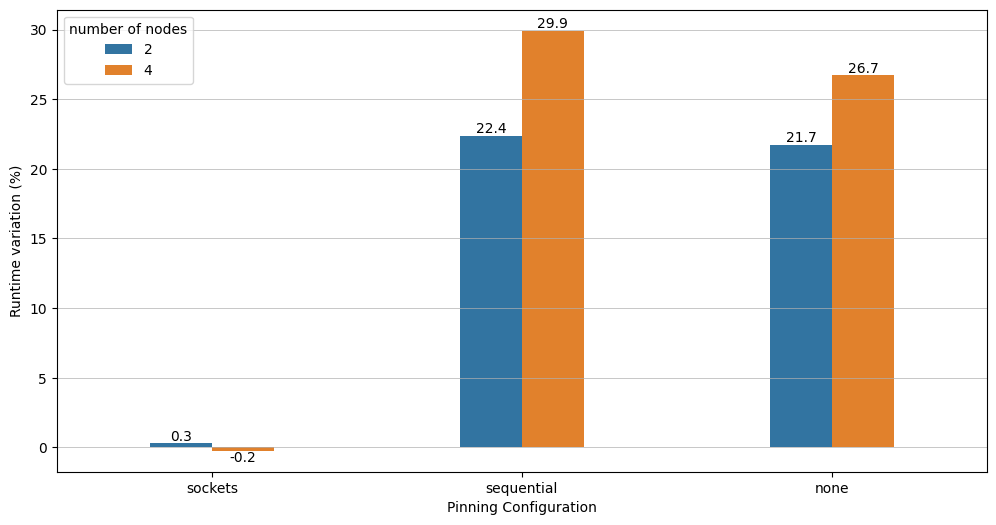

In [32]:
def compare_numab_per_benchmark_per_machine_type(benchmarks: List[Tuple[str, int]], reference_pinning_name = "sockorder", w = 12, h = 6):
    # combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    # We want to average over same number of node
    nodes_values = []
    benchmark_values = []
    variation_values = []
    pinning_values = []
    sample_size_values = []
    for name, n_nodes in benchmarks:
        # print(name)
        variation_to_reference_pinning_by_pinning = compute_variation_between_pinning_for_benchmark_for_nb(
            benchmark_dir_path=in_trace_cmd_dir(name), 
            nb=False, 
            reference_pinning_name=reference_pinning_name
        )
        # variation_to_reference_pinning_by_pinning = compute_variation_by_pinning_for_benchmark(in_trace_cmd_dir(name), reference_pinning_name)
        for pinning_name, (variation, n) in variation_to_reference_pinning_by_pinning.items():
            nodes_values.append(n_nodes)
            benchmark_values.append(benchmark_pretty_name(name))
            variation_values.append(variation)
            pinning_values.append(pinning_name)
            sample_size_values.append(n)
      
    data_df = pd.DataFrame({
        "number of nodes": nodes_values,
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values,
        "size": sample_size_values
    })
    data_df = data_df.loc[data_df["pinning"] != reference_pinning_name]
    # print(datadf)
    data_df["weighted_var"] = data_df["variation"] * data_df["size"]
    aggregate_df = data_df.groupby(['pinning', 'number of nodes']).agg(total_sample=("size", "sum"), total_var=("weighted_var", "sum"))
    aggregate_df["average_var"] = aggregate_df["total_var"] / aggregate_df["total_sample"]
    
    keys = list(omp_pinnings.keys())
    keys.remove(reference_pinning_name)
    ax = sns.barplot(x='pinning', order=keys, y='average_var', hue='number of nodes', data=aggregate_df, palette='tab10', width=0.4)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    plt.xlabel('Pinning Configuration')
    plt.ylabel('Runtime variation (%)')
    print(f'Average Runtime Over All Benchmarks Compared to Pinning Configuration "{reference_pinning_name}" - NUMA balancing OFF\nPositive values means pinning configuration is worse than {reference_pinning_name}')
    plt.show()
    
    
compare_numab_per_benchmark_per_machine_type(combined_benchmarks)

Cannot find /root/results/_trace-cmd/cg.B.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Cannot find /root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-disabled-sockets
Average Runtime Compared to Pinning Configuration "sockorder" - NUMA balancing OFF - Dual-Node Machines
Positive values means pinning configuration is worse than sockorder


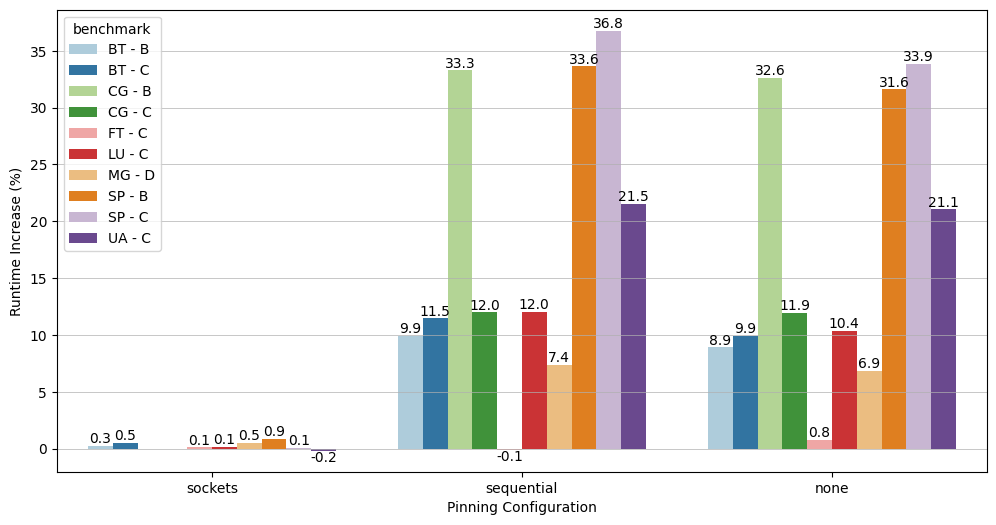

Average Runtime Compared to Pinning Configuration "sockorder" - NUMA balancing OFF - Quad-Node Machines
Positive values means pinning configuration is worse than sockorder


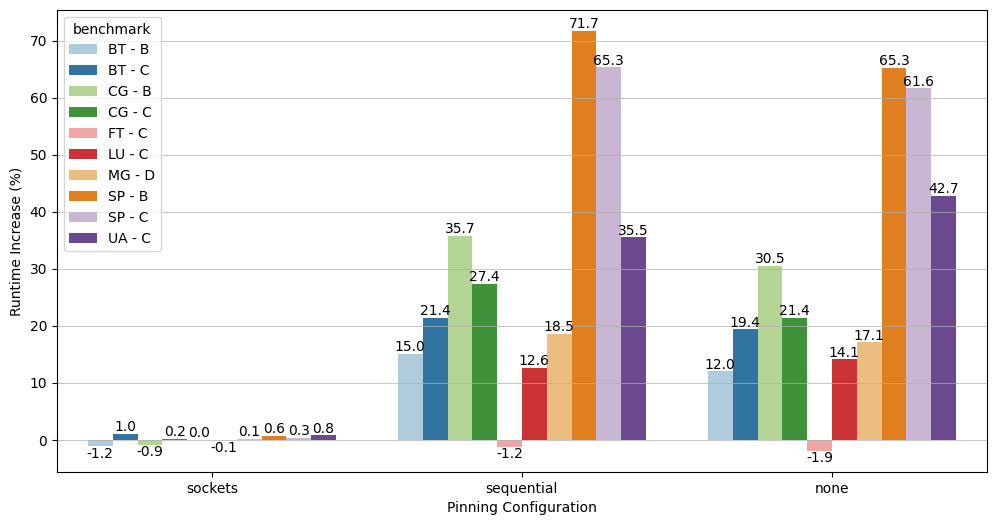

In [35]:
def plot_all_variations_between_pinning_nb_off(benchmarks_names: List[str], n_nodes: int, reference_pinning_name = "sockorder", w = 12, h = 6):
    combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    benchmark_values = []
    variation_values = []
    pinning_values = []
    for name in benchmarks_names:
        variation_to_reference_pinning_by_pinning = compute_variation_between_pinning_for_benchmark_for_nb(
            benchmark_dir_path=in_trace_cmd_dir(name), 
            nb=False, 
            reference_pinning_name=reference_pinning_name
        )
        for pinning_name, (variation, n) in variation_to_reference_pinning_by_pinning.items():
            benchmark_values.append(benchmark_pretty_name(name))
            variation_values.append(variation)
            pinning_values.append(pinning_name)
            combined_results[pinning_name][0] += variation
            
    data_df = pd.DataFrame({
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values
    })
    data_df = data_df.loc[data_df["pinning"] != reference_pinning_name]
    
    ax = sns.barplot(x='pinning', y='variation', hue='benchmark', data=data_df, palette='Paired')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    machine_type = "Dual-Node" if n_nodes == 2 else "Quad-Node"
    print(f'Average Runtime Compared to Pinning Configuration "{reference_pinning_name}" - NUMA balancing OFF - {machine_type} Machines\nPositive values means pinning configuration is worse than {reference_pinning_name}')
    plt.xlabel('Pinning Configuration')
    plt.ylabel(f'Runtime Increase (%)')
    plt.show()

    
plot_all_variations_between_pinning_nb_off(two_nodes_benchmarks, 2)
plot_all_variations_between_pinning_nb_off(four_nodes_benchmarks, 4)

In [126]:
# Deprecated
def plot_all_variations_between_pinning(benchmarks_names: List[str], n_nodes: int, reference_pinning_name = "sockorder", w = 12, h = 6):
    combined_results = {pinning_name: [0.0, 0.0] for pinning_name in omp_pinnings}
    benchmark_values = []
    variation_values = []
    pinning_values = []
    for name in benchmarks_names:
        variation_to_reference_pinning = compute_variation_by_pinning_for_benchmark(in_trace_cmd_dir(name), reference_pinning_name)
        # print(variation_to_reference_pinning)
        for pinning_name, (variation, n) in variation_to_reference_pinning.items():
            benchmark_values.append(benchmark_pretty_name(name))
            variation_values.append(variation)
            pinning_values.append(pinning_name)
            combined_results[pinning_name][0] += variation
            
    data_df = pd.DataFrame({
        "benchmark": benchmark_values,
        "variation": variation_values,
        "pinning": pinning_values
    })
    data_df = data_df.loc[data_df["pinning"] != reference_pinning_name]
    
    sns.barplot(x='pinning', y='variation', hue='benchmark', data=data_df, palette='Paired')
    plt.gcf().set_size_inches(w, h)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    machine_type = "Dual-Node" if n_nodes == 2 else "Quad-Node"
    plt.title(f'Average Runtime Compared to Pinning Configuration "{reference_pinning_name}" - {machine_type} Machines\nPositive values means pinning is worse than reference')
    plt.xlabel('Pinning Configuration')
    plt.ylabel(f'Runtime Increase (%)')
    plt.show()

    
# plot_all_variations_between_pinning(two_nodes_benchmarks, 2)
# plot_all_variations_between_pinning(four_nodes_benchmarks, 4)

['cg.D nb-disabled-none', 'cg.D nb-disabled-sequential', 'cg.D nb-disabled-sockets', 'cg.D nb-disabled-sockorder']


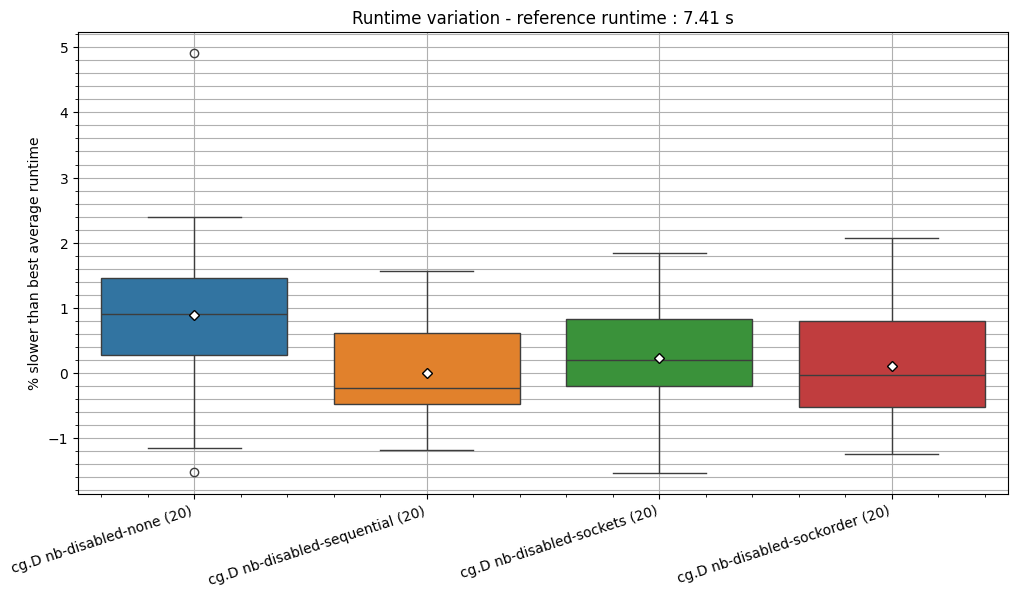

In [75]:
bp = BoxPlotter(USE_TRACE_CMD_CACHE, TRACE_CMD_CACHE_FILENAME)
bp.add_trace_cmd_directory(in_trace_cmd_dir("ft.C.x__dahu-15__v6.8.0-rc3__performance__2024-03-09"), "cg.D")
# bp.show_variations(filters=["sockets", "sockorder", "sequential", "none"], w = 10, h = 6)
bp.show_variations(ordered_filters=["disabled"])

# Tests

In [12]:
# cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26
# nb-enabled-sockorder : 120
# nb-enabled-none : 120
# nb-enabled-sequential : 120
# nb-disabled-sequential : 120
# nb-disabled-sockorder : 120
# nb-disabled-none : 120

print(in_trace_cmd_dir("cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-enabled-none"))

batch_df = get_batch_dataframe(
    in_trace_cmd_dir("cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-enabled-none"), 
    use_cache=True, 
    cache_filename=TRACE_CMD_CACHE_FILENAME, 
    include_broken_wc = False
)

/root/results/_trace-cmd/cg.C.x__dahu-22__v6.8.0-rc3__performance__2024-04-26/nb-enabled-none


In [13]:
batch_df

,filename,duration,exists,run_index,variation
0,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,9.722044,False,108,0.000000
1,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,9.743900,False,29,0.224809
2,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,9.745825,False,94,0.244609
3,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,9.745976,False,109,0.246162
4,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,9.755726,False,112,0.346450
...,...,...,...,...,...
115,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,10.424704,False,98,7.227492
116,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,10.489251,False,84,7.891417
117,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,10.510673,False,69,8.111761
118,cg.C.x__dahu-22__v6.8.0-rc3__performance__2024...,10.545957,False,90,8.474689


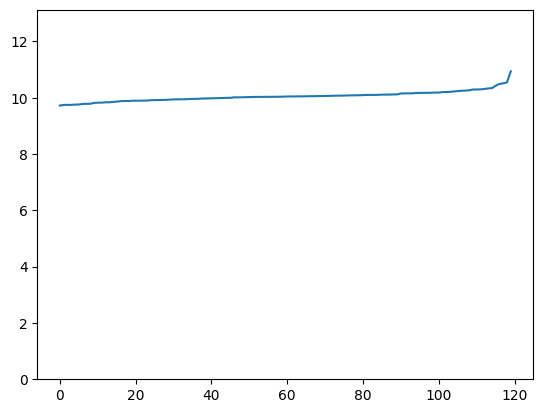

In [14]:
time_values = sorted(batch_df["duration"])
plt.plot(range(len(time_values)), time_values)
plt.ylim(0, time_values[-1] * 1.2)
plt.show()